In [0]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

### Задание 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)
Я в функцию build_tree добавил условие на глубину дерева (if quality == 0 or deep == 2). При каждом рекурсивном вызове глубина увеличивается на 1. Для наглядности поставил условие глубины 2.

In [0]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

In [0]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [0]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction 

In [0]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [0]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [0]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [0]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [0]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, deep):
    deep += 1
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or deep == 2:
        return Leaf(data, labels)
    # if deep == 3:
    #     return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, deep)
    false_branch = build_tree(false_data, false_labels, deep)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [0]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [0]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [0]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [0]:
# Построим дерево по обучающей выборке
start_deep = 0
my_tree = build_tree(train_data, train_labels, start_deep)

In [0]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [0]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [0]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [0]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [0]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

Text(0.5, 1.0, 'Test accuracy=96.67')

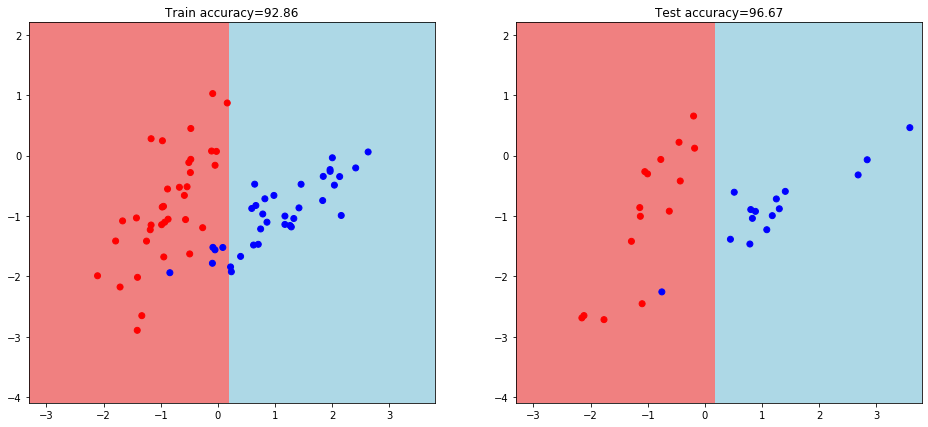

In [0]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

### Задание 2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

Для этой задачи я сгенерировал новый датасет для регрессии. Заменил функцию predict в классе Leaf на подсчет среднего по данным. Критерий Джинни заменил на подсчет дисперсии. В функции подсчета точности accuracy_metric высчитываю MSE, но никак не могу понять почему получаются какие-то заоблачные значения. Видимо это задание считается невыполненным.

In [0]:
# сгенерируем данные
data, target, coef = datasets.make_regression(n_samples=1000, n_features = 2, n_informative = 2, n_targets = 1, 
                                              noise = 5, coef = True, random_state = 2)


In [0]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [0]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # Посчитаем среднее значение
        prediction = np.mean(self.data)
        return prediction 

In [0]:
# Расчет дисперсии вместо критерия Джини

def dispersion(labels):  
    disp = sum((labels - np.mean(labels))**2) / len(labels)
        
    return disp

In [0]:
# Расчет качества

def quality(left_labels, right_labels, current_dispersion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_dispersion - p * dispersion(left_labels) - (1 - p) * dispersion(right_labels)

In [0]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [0]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_dispersion = dispersion(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_dispersion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [0]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [0]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [0]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [0]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_target, test_target = model_selection.train_test_split(data, 
                                                                                     target, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [0]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_target)

In [0]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [0]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [0]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    # correct = 0
    # for i in range(len(actual)):
    #     if actual[i] == predicted[i]:
    #         correct += 1
    # return correct / float(len(actual)) * 100.0
    return np.sum((actual - predicted)**2) / len(actual)

In [0]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_target, train_answers)
train_accuracy

8570.771152087804

In [0]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_target, answers)
test_accuracy

6898.996211507291

Text(0.5, 1.0, 'Test accuracy=6899.00')

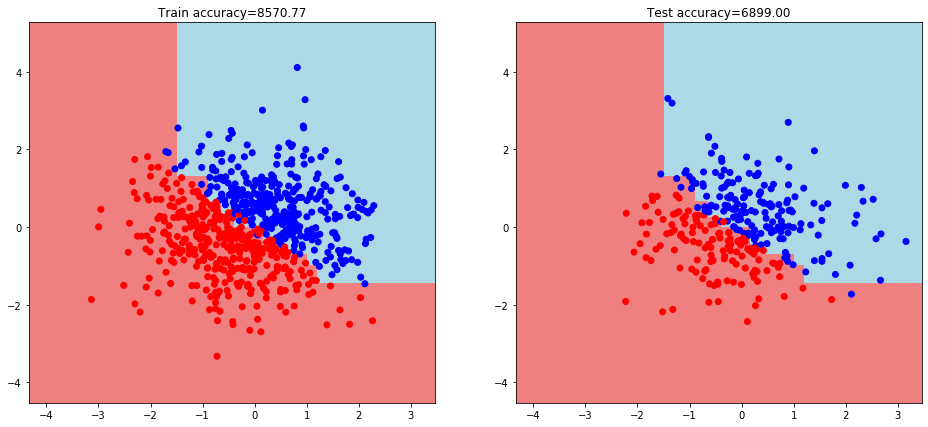

In [0]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_target, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_target, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')